# Transfer Learning

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
        'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [5]:
data_dir = 'data/hymenoptera/'
sets = ['train','val']
images_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                   for x in ['train', 'val']}

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(images_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=0)
               for x in ['train', 'val']}

In [7]:
dataset_sizes = {x: len(images_datasets[x]) for x in ['train', 'val']}
class_names = images_datasets['train'].classes
print(class_names)

['ants', 'bees']


In [8]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1,2,0))
    inp = std * inp + mean
    inp = np.clip(inp, 0,1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()  

In [9]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

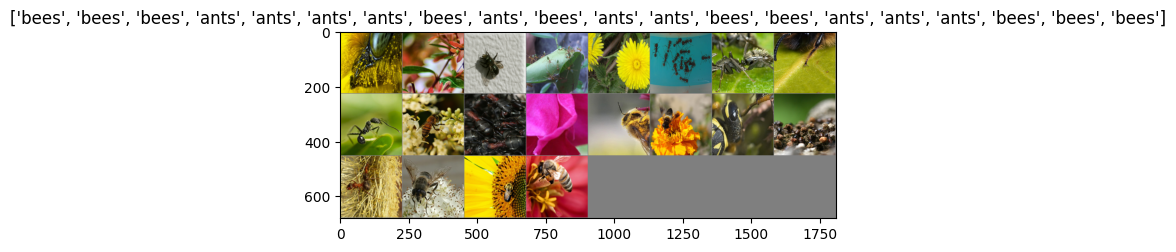

In [10]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [11]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs-1}')
#         print('-'*10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train() # Set model to training mode
#             else:
#                 model.eval() # Set model to evaluate mode
            
#             running_loss = 0.0
#             running_corrects = 0
#             # iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 #forward
#                 #tracking history if only train
#                 with torch.set_grad_enabled(phase =='train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)
    
#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         optimizer.zero_grad()
#                         optimizer.step()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)
    
#             if phase == 'train':
#                 scheduler.step()
        
#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#             # deep copy the model
#             if phase =='val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
#     print(f'Best val Acc:{best_acc:4f}')
    
#     #load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## resnet18 Model Option 1

In [13]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

/home/john/Documents/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/john/Documents/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [15]:
#scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7, gamma=0.1)

In [16]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.8138 Acc: 0.4262
val Loss: 0.7435 Acc: 0.4641

Epoch 1/19
----------
train Loss: 0.7046 Acc: 0.5656
val Loss: 0.6312 Acc: 0.6471

Epoch 2/19
----------
train Loss: 0.6162 Acc: 0.6844
val Loss: 0.5482 Acc: 0.7451

Epoch 3/19
----------
train Loss: 0.5555 Acc: 0.7295
val Loss: 0.4852 Acc: 0.8105

Epoch 4/19
----------
train Loss: 0.4976 Acc: 0.7992
val Loss: 0.4417 Acc: 0.8497

Epoch 5/19
----------
train Loss: 0.4822 Acc: 0.8074
val Loss: 0.4255 Acc: 0.8693

Epoch 6/19
----------
train Loss: 0.4584 Acc: 0.8156
val Loss: 0.4039 Acc: 0.8824

Epoch 7/19
----------
train Loss: 0.4364 Acc: 0.8402
val Loss: 0.3991 Acc: 0.8824

Epoch 8/19
----------
train Loss: 0.4214 Acc: 0.8648
val Loss: 0.3974 Acc: 0.8824

Epoch 9/19
----------
train Loss: 0.4451 Acc: 0.8156
val Loss: 0.3828 Acc: 0.9085

Epoch 10/19
----------
train Loss: 0.4269 Acc: 0.8525
val Loss: 0.3807 Acc: 0.9085

Epoch 11/19
----------
train Loss: 0.4161 Acc: 0.8402
val Loss: 0.3782 Acc: 0.9085

Ep

## resnet18 Model Option 2

In [17]:
# Freeze al the layer on the beginning
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad= False # Frezee al the layer on the beginnig

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [19]:
#scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7, gamma=0.1)

In [20]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.8142 Acc: 0.4262
val Loss: 0.7523 Acc: 0.4902

Epoch 1/19
----------
train Loss: 0.7554 Acc: 0.4713
val Loss: 0.6776 Acc: 0.5817

Epoch 2/19
----------
train Loss: 0.6897 Acc: 0.5738
val Loss: 0.6542 Acc: 0.6013

Epoch 3/19
----------
train Loss: 0.6348 Acc: 0.6189
val Loss: 0.5935 Acc: 0.6993

Epoch 4/19
----------
train Loss: 0.5942 Acc: 0.7008
val Loss: 0.5412 Acc: 0.7647

Epoch 5/19
----------
train Loss: 0.5580 Acc: 0.7459
val Loss: 0.5010 Acc: 0.7778

Epoch 6/19
----------
train Loss: 0.5037 Acc: 0.8361
val Loss: 0.4700 Acc: 0.8301

Epoch 7/19
----------
train Loss: 0.4892 Acc: 0.7951
val Loss: 0.4694 Acc: 0.8301

Epoch 8/19
----------
train Loss: 0.4965 Acc: 0.7869
val Loss: 0.4593 Acc: 0.8497

Epoch 9/19
----------
train Loss: 0.5082 Acc: 0.7992
val Loss: 0.4635 Acc: 0.8431

Epoch 10/19
----------
train Loss: 0.4966 Acc: 0.8033
val Loss: 0.4613 Acc: 0.8366

Epoch 11/19
----------
train Loss: 0.4916 Acc: 0.8074
val Loss: 0.4577 Acc: 0.8627

Ep